In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv("dataset4.csv")
data

,x1,x2,x3
0,7.4,18.1,11.0
1,11.3,19.1,10.9
2,6.8,17.8,11.5
3,10.3,19.7,10.9
4,7.0,20.1,11.9
...,...,...,...
995,9.5,16.5,11.4
996,8.9,19.6,10.7
997,8.3,19.4,11.3
998,9.4,19.2,12.3


<IPython.core.display.Javascript object>


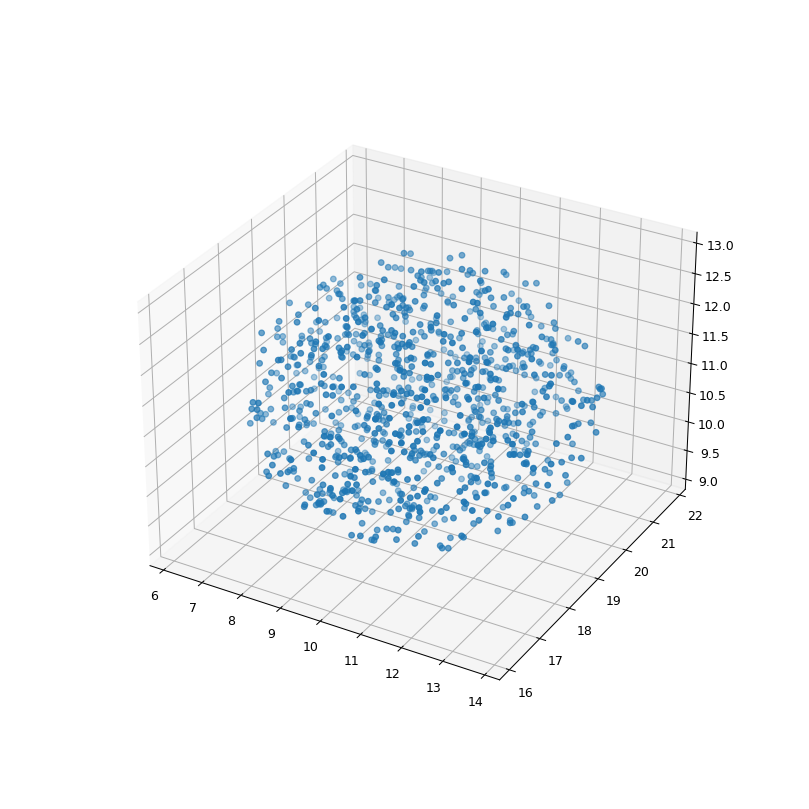

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(data["x1"], data["x2"], data["x3"])

In [6]:
from numpy.linalg import eig, inv

#least squares fit to a 3D-ellipsoid
#  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz  = 1
#
# Note that sometimes it is expressed as a solution to
#  Ax^2 + By^2 + Cz^2 + 2Dxy + 2Exz + 2Fyz + 2Gx + 2Hy + 2Iz  = 1
# where the last six terms have a factor of 2 in them
# This is in anticipation of forming a matrix with the polynomial coefficients.
# Those terms with factors of 2 are all off diagonal elements.  These contribute
# two terms when multiplied out (symmetric) so would need to be divided by two

def ls_ellipsoid(xx,yy,zz):                                  
    #finds best fit ellipsoid. Found at http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html
    #least squares fit to a 3D-ellipsoid
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz  = 1
    #
    # Note that sometimes it is expressed as a solution to
    #  Ax^2 + By^2 + Cz^2 + 2Dxy + 2Exz + 2Fyz + 2Gx + 2Hy + 2Iz  = 1
    # where the last six terms have a factor of 2 in them
    # This is in anticipation of forming a matrix with the polynomial coefficients.
    # Those terms with factors of 2 are all off diagonal elements.  These contribute
    # two terms when multiplied out (symmetric) so would need to be divided by two
    
    # change xx from vector of length N to Nx1 matrix so we can use hstack
    x = xx[:,np.newaxis]
    y = yy[:,np.newaxis]
    z = zz[:,np.newaxis]
    
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz = 1
    J = np.hstack((x*x,y*y,z*z,x*y,x*z,y*z, x, y, z))
    K = np.ones_like(x) #column of ones
    
    #np.hstack performs a loop over all samples and creates
    #a row in J for each x,y,z sample:
    # J[ix,0] = x[ix]*x[ix]
    # J[ix,1] = y[ix]*y[ix]
    # etc.
    
    JT=J.transpose()
    JTJ = np.dot(JT,J)
    InvJTJ=np.linalg.inv(JTJ);
    ABC= np.dot(InvJTJ, np.dot(JT,K))

    # Rearrange, move the 1 to the other side
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz - 1 = 0
    #    or
    #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz + J = 0
    #  where J = -1
    eansa=np.append(ABC,-1)

    return (eansa)

   

In [7]:
def polyToParams3D(vec,printMe):                             
    #gets 3D parameters of an ellipsoid. Found at http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html
    # convert the polynomial form of the 3D-ellipsoid to parameters
    # center, axes, and transformation matrix
    # vec is the vector whose elements are the polynomial
    # coefficients A..J
    # returns (center, axes, rotation matrix)
    
    #Algebraic form: X.T * Amat * X --> polynomial form
    
    if printMe: print('\npolynomial\n',vec)
    
    Amat=np.array(
    [
    [ vec[0],     vec[3]/2.0, vec[4]/2.0, vec[6]/2.0 ],
    [ vec[3]/2.0, vec[1],     vec[5]/2.0, vec[7]/2.0 ],
    [ vec[4]/2.0, vec[5]/2.0, vec[2],     vec[8]/2.0 ],
    [ vec[6]/2.0, vec[7]/2.0, vec[8]/2.0, vec[9]     ]
    ])
    
    if printMe: print('\nAlgebraic form of polynomial\n',Amat)
    
    #See B.Bartoni, Preprint SMU-HEP-10-14 Multi-dimensional Ellipsoidal Fitting
    # equation 20 for the following method for finding the center
    A3=Amat[0:3,0:3]
    A3inv=inv(A3)
    ofs=vec[6:9]/2.0
    center=-np.dot(A3inv,ofs)
    if printMe: print('\nCenter at:',center)
    
    # Center the ellipsoid at the origin
    Tofs=np.eye(4)
    Tofs[3,0:3]=center
    R = np.dot(Tofs,np.dot(Amat,Tofs.T))
    if printMe: print('\nAlgebraic form translated to center\n',R,'\n')
    
    R3=R[0:3,0:3]
    R3test=R3/R3[0,0]
    # print('normed \n',R3test)
    s1=-R[3, 3]
    R3S=R3/s1
    (el,ec)=eig(R3S)
    
    recip=1.0/np.abs(el)
    axes=np.sqrt(recip)
    if printMe: print('\nAxes are\n',axes  ,'\n')
    
    inve=inv(ec) #inverse is actually the transpose here
    if printMe: print('\nRotation matrix\n',inve)
    return (center,axes,inve)


In [8]:
def printAns3D(center,axes,R,xin,yin,zin,verbose):

      print("\nCenter at  %10.4f,%10.4f,%10.4f" % (center[0],center[1],center[2]))
      print("Axes gains %10.4f,%10.4f,%10.4f " % (axes[0],axes[1],axes[2]))
      print("Rotation Matrix\n%10.5f,%10.5f,%10.5f\n%10.5f,%10.5f,%10.5f\n%10.5f,%10.5f,%10.5f" % (
      R[0,0],R[0,1],R[0,2],R[1,0],R[1,1],R[1,2],R[2,0],R[2,1],R[2,2]))


      # Check solution
      # Convert to unit sphere centered at origin
      #  1) Subtract off center
      #  2) Rotate points so bulges are aligned with axes (no xy,xz,yz terms)
      #  3) Scale the points by the inverse of the axes gains
      #  4) Back rotate
      # Rotations and gains are collected into single transformation matrix M

      # subtract the offset so ellipsoid is centered at origin
      xc=xin-center[0]
      yc=yin-center[1]
      zc=zin-center[2]

      # create transformation matrix
      L = np.diag([1/axes[0],1/axes[1],1/axes[2]])
      M=np.dot(R.T,np.dot(L,R))
      print('\nTransformation Matrix\n',M)

      # apply the transformation matrix
      [xm,ym,zm]=np.dot(M,[xc,yc,zc])
      # Calculate distance from origin for each point (ideal = 1.0)
      rm = np.sqrt(xm*xm + ym*ym + zm*zm)

      print("\nAverage Radius  %10.4f (truth is 1.0)" % (np.mean(rm)))
      print("Stdev of Radius %10.4f\n " % (np.std(rm)))

      return


In [9]:
x1 = np.array(data["x1"])
x2 = np.array(data["x2"])
x3 = np.array(data["x3"])
ls_ellipsoid(x1,x2,x3)

array([-3.29913554e-04, -1.07869848e-03, -1.86474347e-03, -3.11325471e-04,
       -3.41029367e-04, -1.25873782e-03,  1.62449078e-02,  5.78520950e-02,
        6.82353735e-02, -1.00000000e+00])

In [10]:
#let us assume some definition of x, y and z

#get convex hull
surface  = np.stack((x1,x2,x3), axis=-1)
hullV    = ConvexHull(surface)
lH       = len(hullV.vertices)
hull     = np.zeros((lH,3))
for i in range(len(hullV.vertices)):
    hull[i] = surface[hullV.vertices[i]]
hull     = np.transpose(hull)         
            
#fit ellipsoid on convex hull
eansa            = ls_ellipsoid(hull[0],hull[1],hull[2]) #get ellipsoid polynomial coefficients
print("coefficients:"  , eansa)
center,axes,inve = polyToParams3D(eansa,False)   #get ellipsoid 3D parameters
print("center:"        , center)
print("axes:"          , axes)
print("rotationMatrix:", inve)

coefficients: [-8.22244123e-04 -1.47926595e-03 -3.23681650e-03  1.75143457e-05
  3.54691385e-06 -4.55742492e-05  1.61166235e-02  5.64753965e-02
  7.19876165e-02 -1.00000000e+00]
center: [10.02622938 18.97902358 10.99200773]
axes: [3.87780797 2.8910714  1.9542345 ]
rotationMatrix: [[-9.99911314e-01 -1.33039083e-02 -6.08832541e-04]
 [-1.32948919e-02  9.99827431e-01 -1.29751285e-02]
 [-7.81347395e-04  1.29658834e-02  9.99915634e-01]]
